## Cбор данных, дёшево и сердито

Почти всегда **данные** на интересующих нас с вами страницах сразу **окажутся в запрашиваемом нами HTML** (а не, скажем, подтягиваются AJAX). Мы рассмотрим только такой случай и построим небольшой датасет по сайту superjob (не рассказывайте им!).


##### Замечание
_Круто, когда мы можем просто взять список нужных нам страниц, скачать и распарсить их (как сейчас), но иногда приходится ползать по страницам, переходить по ссылкам, поддерживать очередь адресов для скачивания и так далее... Всё это умеет делать [scrapy](https://doc.scrapy.org/en/latest/). Он классный._

In [5]:
! curl 'https://www.superjob.ru/robots.txt' | grep sitemap

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3320  100  3320    0     0   7831      0 --:--:-- --:--:-- --:--:--  7830
Sitemap: https://www.superjob.ru/sitemap_index.xml
Sitemap: https://www.superjob.ru/sitemap_index.xml


Можно открыть, посмотреть, чем суперджоб делится с индексирующими роботами и всеми желащими.

Скорее всего, там будут не все данные, которые есть на сайте, но часто хватает и этого.


Список компаний (sitemap_clients), список соискателей (sitemap_resume), список вакансий и прочее. 

Давайте что-нибудь скачаем.

In [6]:
# это можно делать и из питона, но из консоли, кажется, проще?
! curl 'https://www.superjob.ru/sitemap_index.xml' | grep 'sitemap_resume' | sed -e 's/<[^>]*>//g'
! curl 'https://www.superjob.ru/sitemap_index.xml' | grep 'sitemap_resume' | sed -e 's/<[^>]*>//g' | xargs curl | grep http | sed -e 's/<[^>]*>//g' > resume-urls.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4040  100  4040    0     0   8010      0 --:--:-- --:--:-- --:--:--  8000
https://www.superjob.ru/sitemap_resume_1.xml
https://www.superjob.ru/sitemap_resume_2.xml
https://www.superjob.ru/sitemap_resume_3.xml
https://www.superjob.ru/sitemap_resume_4.xml
https://www.superjob.ru/sitemap_resume_5.xml
https://www.superjob.ru/sitemap_resume_6.xml
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4040  100  4040    0     0  10072      0 --:--:-- --:--:-- --:--:-- 10100
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4363k  100 4363k    0     0  2579k      0  0:00:01  0:00:01 --:--:-- 2578k
100 4382k  100 4382

In [121]:
import urllib.request
import re

html = urllib.request.urlopen("https://www.superjob.ru/sitemap_index.xml").read().decode("utf-8")

with open("resume-urls2.txt", "w+") as wf:
    for line in html.split("\n"):
        if "sitemap_resume" in line:
            print(line)
            url = re.sub("<[^>]+>", "", line)
            for l in urllib.request.urlopen(url).read().decode("utf-8").split("\n"):
                if "http" in l and "superjob.ru" in l:
                    url_resume = re.sub("<[^>]+>", "", l)
                    wf.write(url_resume + "\n")


<loc>https://www.superjob.ru/sitemap_resume_1.xml</loc>
<loc>https://www.superjob.ru/sitemap_resume_2.xml</loc>
<loc>https://www.superjob.ru/sitemap_resume_3.xml</loc>
<loc>https://www.superjob.ru/sitemap_resume_4.xml</loc>
<loc>https://www.superjob.ru/sitemap_resume_5.xml</loc>
<loc>https://www.superjob.ru/sitemap_resume_6.xml</loc>


In [122]:
for line in open("resume-urls2.txt"):
    print(line)
    break

https://www.superjob.ru/resume/glavnyj-buhgalter-893.html



In [124]:
urls_list = [line.strip() for line in open("resume-urls2.txt") if line.strip()]

len(urls_list), urls_list[:10]

(276310,
 ['https://www.superjob.ru/resume/glavnyj-buhgalter-893.html',
  'https://www.superjob.ru/resume/yuriskonsult-1741.html',
  'https://www.superjob.ru/resume/inzhener-2075.html',
  'https://www.superjob.ru/resume/hudozhnik-dizajner-3533.html',
  'https://www.superjob.ru/resume/buhgalter-9953.html',
  'https://www.superjob.ru/resume/direktor-11975.html',
  'https://www.superjob.ru/resume/direktor-12388.html',
  'https://www.superjob.ru/resume/biznes-trener-17423.html',
  'https://www.superjob.ru/resume/ekonomist-17768.html',
  'https://www.superjob.ru/resume/rukovoditel-18200.html'])

И здесь бы я воспользовался консолью, проще всего это всё скачать wget-ом, а потом экспериментировать сколько угодно (у wget очень много настроек, которые можно включить-выключить, а не думать, как это проще запрограммировать). Но давайте воспользуемся какой-нибудь питоновской библиотекой.

In [18]:
! mkdir cv_data

mkdir: cannot create directory ‘cv_data’: File exists


In [19]:
import urllib.request
from tqdm import tqdm

for url in tqdm(urls_list[:10]):
    
    response = urllib.request.urlopen(url)
    data = response.read()  # a `bytes` object, not a string yet!
    text = data.decode('utf-8')
    
    with open("cv_data/" + url.split("/")[-1], "w+") as wf:
        wf.write(text)

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


На самом деле, это так не работает. Легко забанят за много запросов с одного айпишника, будут ставить долгое время ответа, всё такое. Оно и понятно: бесполезная нагрузка на сервер, кража важных для бизнеса данных.

Поэтому, если ОЧЕНЬ НАДО, иногда приходится скачивать через прокси, ставить правильные случайные задержки, подменять User-Agent -- и всё такое.

In [126]:
import urllib.request
from tqdm import tqdm
from random import randint
import time

for url in tqdm(urls_list):
    
    # print(url)
    
    req = urllib.request.Request(
        url, 
        data=None, 
        # подсмотреть самые попсовые можно, например, здесь:
        # https://techblog.willshouse.com/2012/01/03/most-common-user-agents/
        headers={
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 " + \
                            "(KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36"
        }
    )

    response = urllib.request.urlopen(req)
    data = response.read()  # a `bytes` object, not a string yet!
    text = data.decode('utf-8')
    
    # сохраняем страницу полностью, чтобы потом можно было спокойно экспериментировать без сети
    with open("cv_data/" + url.split("/")[-1], "w+") as wf:
        wf.write(text)

In [127]:
import os

for f in os.listdir("cv_data/")[:5]:
    print(f)

specialist-112548.html
menedzher-po-naruzhnoj-reklame-225828.html
rukovoditel-otdela-prodazh-192299.html
direktor-po-eksportu-246820.html
menedzher-vystavochnyh-proektov-128348.html


Откроем в браузере и посмотрим, что мы понаскачивали и как будем выдирать эти данные.

В заголовке, как на всех условно достойных сайтах, есть слабенькая метаразметка, из которой можно что-то взять.

А вообще HTML весьма недружелюбный и как будто специально обфусцированный: неговорящие названия классов и вообще имена элементов. Попробуем, может, что-то извлечётся, если взять **xpath/selector** из браузера и применить к нескольким страницам.

In [2]:
# запрос на выделение зарплаты из страницы
xpath_salary = "//*[@id=\"app\"]/div[1]/div[3]/div/div[2]/div/div/div/div[4]/div/div[1]/div[1]/div/div/div/div/div[2]/span/span/span[1]/span"

Вообще-то **scrapy** хорош не только для этого, но для выделения данных по xpath у него удобный API

In [3]:
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import os

for f in os.listdir("cv_data/")[:10]:
    body = open("cv_data/" + f, encoding="utf-8").read()
    extracted = Selector(text=body).xpath(xpath_salary).extract()
    print(" ".join([el for el in extracted]))

<span class="_1h3Zg ADNB4 _1BoTZ"><span><span>40 000</span> <span>₽</span></span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span><span>45 000</span> <span>₽</span></span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span>По договорённости</span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span>По договорённости</span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span><span>60 000</span> <span>₽</span></span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span>По договорённости</span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span>По договорённости</span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span>По договорённости</span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span><span>129 000</span> <span>₽</span></span></span>
<span class="_1h3Zg ADNB4 _1BoTZ"><span><span>80 000</span> <span>₽</span></span></span>


In [4]:
from bs4 import BeautifulSoup
import pandas as pd

my_xpaths = [
    (xpath_salary, "expected_salary"),
    ("//*[@id=\"app\"]/div[1]/div[3]/div/div[2]/div/div/div/div[1]/div/span[1]", "user_id"),
    ("//*[@id=\"app\"]/div[1]/div[3]/div/div[2]/div/div/div/div[4]/div/div[1]/div[2]/div[1]/div/div/div[1]/div/div/div[1]/div/h2/span/span/span[1]", "years_work"),
    ("//*[@id=\"app\"]/div[1]/div[3]/div/div[2]/div/div/div/div[3]/div/div/div[1]/div/div/div/div/div/div/div/div/span/div/div[1]/span/span[1]/span/span[1]", "age"),
    ('//*[@id="app"]/div[1]/div[3]/div/div[2]/div/div/div/div[3]/div/div/div[1]/div/div/div/div/div/div/div/div/span/div/div[2]/span/span[1]', "city"),
    ('//*[@id="app"]/div[1]/div[3]/div/div[2]/div/div/div/div[2]/div/span/span/span[3]/span/a', "industry"),
    ('//*[@id="app"]/div[1]/div[3]/div/div[2]/div/div/div/div[4]/div/div[1]/div[1]/div/div/div/div/div[1]/h1', "job")
    # ваши xpath-ы
]

resulting_df = [{}]

for f in os.listdir("cv_data/"):
    
    body = open("cv_data/" + f, encoding="utf-8").read()
    
    for xpath, key_name in my_xpaths:
    
        extracted = Selector(text=body).xpath(xpath).extract()

        for e in extracted:
            
            soup = BeautifulSoup(e, 'html.parser')
            just_text = soup.get_text()
            resulting_df[-1][key_name] = just_text
            
    resulting_df.append({})

resulting_df = resulting_df[:-1]    

scraped_df = pd.DataFrame(resulting_df)
scraped_df.to_csv("superjob_df.csv")
scraped_df.shape, scraped_df.head()

((174, 7),        age    city    expected_salary  \
 0   45 лет  Москва           40 000 ₽   
 1   61 год  Москва           45 000 ₽   
 2  54 года  Москва  По договорённости   
 3  52 года  Москва  По договорённости   
 4   39 лет  Москва           60 000 ₽   
 
                                     industry  \
 0      Секретариат, ресепшн, офис-менеджмент   
 1                           Наружная реклама   
 2                                    Продажи   
 3  Административная работа, секретариат, АХО   
 4                       Управление проектами   
 
                                                  job   user_id years_work  
 0                              Специалист / менеджер  № 112548     21 год  
 1                       Менеджер по наружной рекламе  № 225828     39 лет  
 2   Руководитель отдела продаж, директор по продажам  № 192299     30 лет  
 3  Директор по экспорту / Директор по международн...  № 246820     28 лет  
 4                      Менеджер выставочных проектов  

In [5]:
scraped_df.city.unique()

array(['Москва'], dtype=object)

In [6]:
# len(scraped_df.industry.unique()), scraped_df.industry.unique()

In [7]:
len(scraped_df.job.unique())

166

## Посмотрим на слова

In [8]:
import re
from sklearn.feature_extraction.text import CountVectorizer

nonalpha = re.compile("\W+", re.U)

def fix(txt):
    return " ".join(nonalpha.split(txt.lower()))

vect = CountVectorizer()
counts = vect.fit_transform(scraped_df.job.map(fix))

len(vect.vocabulary_)

277

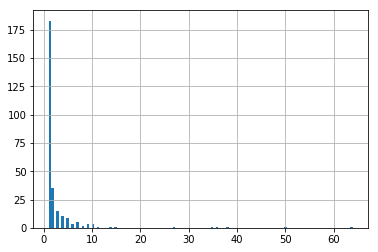

In [9]:
%matplotlib inline
pd.Series(counts.sum(axis=0).A1).hist(bins=120)

In [10]:
import re
from sklearn.feature_extraction.text import CountVectorizer

nonalpha = re.compile("\W+", re.U)

def fix(txt):
    return " ".join(nonalpha.split(txt.lower()))

vect = CountVectorizer(max_features=100, min_df=2)
counts = vect.fit_transform(scraped_df.job.map(fix))

# len(vect.vocabulary_), vect.vocabulary_

In [11]:
newdf = []

inverse_voc = {id: word for (word, id) in vect.vocabulary_.items()}

for row in counts:
    row = row.todense().A1
    newrow = {}
    for id, v in enumerate(row):
        newrow[inverse_voc[id]] = v
    newdf.append(newrow)
    
    
newdf = pd.DataFrame(newdf)
newdf.head()

1с  it  административный  администратор  аналитик  архитектор  ассистент  \
0   0   0                 0              0         0           0          0   
1   0   0                 0              0         0           0          0   
2   0   0                 0              0         0           0          0   
3   0   0                 0              0         0           0          0   
4   0   0                 0              0         0           0          0   

   ахо  банка  бухгалтер  ...    стратегическому  технический  управления  \
0    0      0          0  ...                  0            0           0   
1    0      0          0  ...                  0            0           0   
2    0      0          0  ...                  0            0           0   
3    0      0          0  ...                  0            0           0   
4    0      0          0  ...                  0            0           0   

   управляющий  финансовый  экономист  юридического  юридической  \
0            0           0          0             0            0   
1            0           0          0             0            0   
2            0           0          0             0            0   
3            0           0          0             0            0   
4            0           0          0             0            0   

   юрисконсульт  юрист  
0             0      0  
1             0      0  
2             0      0  
3             0      0  
4             0      0  

[5 rows x 83 columns]

## *Задание: какие числа в топе?

## Посмотрим на числа

In [12]:
import re 

num = re.compile("\d+", re.U)
whitespace = re.compile("\s+", re.U)

def extract_num(s):
    
    if type(s) == str and not num.search(s) is None and s != "None":
        return int(num.search(whitespace.sub("", s)).group(0)) 
    else: 
        return None

In [34]:
from sklearn.preprocessing import LabelEncoder

scraped_df["age_i"] = scraped_df["age"].map(extract_num).fillna(0).astype(int) # not the best way to do it
scraped_df["expected_salary_i"] = scraped_df["expected_salary"].map(extract_num)
scraped_df["years_work_i"] = scraped_df["years_work"].map(extract_num).fillna(0).astype(int)  # not the best way to do it

le = LabelEncoder()
scraped_df["industry_i"] = le.fit_transform(scraped_df["industry"].fillna(""))

scraped_df_extended = pd.concat([scraped_df, newdf], axis=1)

scraped_df_filtered = scraped_df_extended[scraped_df_extended.expected_salary_i.notnull()]

In [37]:
y = scraped_df_filtered["expected_salary_i"].astype(int).values

scraped_df_filtered_features = scraped_df_filtered.drop(["expected_salary_i", 
                                                "expected_salary",
                                                "years_work",
                                                "industry",
                                                "job",
                                                "user_id",
                                                "city",
                                                "age"], axis=1)
print(scraped_df_filtered_features.columns)
X = scraped_df_filtered_features.values

X.shape, y.shape

Index(['age_i', 'years_work_i', 'industry_i', '1с', 'it', 'административный',
       'администратор', 'аналитик', 'архитектор', 'ассистент', 'ахо', 'банка',
       'бухгалтер', 'бухгалтера', 'ведущий', 'внешнеэкономической', 'вопросам',
       'генерального', 'генеральный', 'главного', 'главный', 'группы',
       'делами', 'департамента', 'деятельности', 'дизайнер', 'директор',
       'директора', 'закупкам', 'заместитель', 'инженер', 'исполнительный',
       'ит', 'качеству', 'кладовщик', 'клиентами', 'коммерческий',
       'конструктор', 'консультант', 'контролер', 'копирайтер', 'логистика',
       'логистики', 'маркетингу', 'менеджер', 'механик', 'направления',
       'направлениям', 'начальник', 'начальника', 'общим', 'отдела', 'офис',
       'переводчик', 'писатель', 'по', 'помощник', 'предприятия', 'продаж',
       'продажам', 'проекта', 'проектов', 'работе', 'развитию', 'разработчик',
       'региональный', 'редактор', 'рекламе', 'руководитель', 'руководителя',
       'сайта', '

((94, 86), (94,))

In [38]:
y.mean(), y.std()

(105132.9574468085, 80342.46799024874)

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

regressor = RandomForestRegressor(min_samples_leaf=1, n_estimators=600, n_jobs=7)

# скользящий контроль с поддержанием распредения доль элементов классов в каждом из кусков
kfold = KFold(n_splits=3, shuffle=True, random_state=7707)

for train_idx, test_idx in kfold.split(X, y):
    
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    regressor.fit(X_train, y_train)
    
    y_pred_on_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)
    
    # less is better
    print("Goodness of fit:", mean_absolute_error(y_train, y_pred_on_train))
    print("Holdout fold   :", mean_absolute_error(y_test, y_pred))
    print()

Goodness of fit: 16781.05295698925
Holdout fold   : 45197.85619791667

Goodness of fit: 19466.58473544973
Holdout fold   : 41373.92424731183

Goodness of fit: 16668.880132275128
Holdout fold   : 62329.86672043011



# Задание: скачайте ещё данных, добавьте фич, чтобы понизить MAE + сравните с DummyRegressor